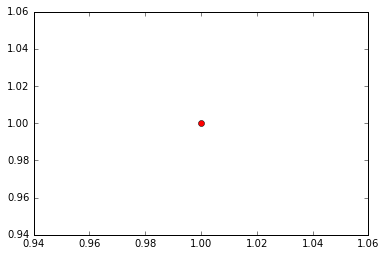

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(1,1,'ro')

In [2]:
import GPflow
import numpy as np
import tensorflow as tf
import AssignGPGibbsSingleLoop
import BranchingTree as bt
np.set_printoptions(precision=4) # precision to print numpy array
import branch_kernParamGPflow as bk
import time
import assigngp_dense 

# Draw a sample from the kernel

------------------1(10)[2,3]
Branching kernel
unnamed.white.variance transform:+ve prior:None
[ 0.001]
unnamed.branchkernelparam.Bv transform:(none) prior:None
[[ 10.]]
unnamed.branchkernelparam.kern.lengthscales transform:+ve prior:None
[ 10.]
unnamed.branchkernelparam.kern.variance transform:+ve prior:None
[ 1.]


/home/mqbssaby/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:48: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


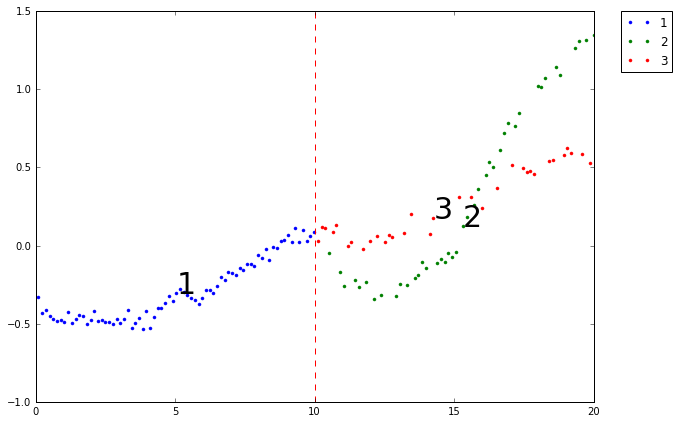

In [3]:
# Try some really easy examples
#seed,N,D = 321113,100,2
#seed,N,D = 626,3,1 # toy example for debugging

# Branching tree 
iChoose = 2
if(iChoose == 1):
    seed,N,D = 938,420,1
    lenScale = 5

    tree = bt.BinaryBranchingTree(0,20)
    tree.add(None,1,3)
    tree.add(1,2,6)
    #tree.add(1,3,12)
elif(iChoose == 2):    
    seed,N,D = 2263,150,1
    lenScale = 10
    
    tree = bt.BinaryBranchingTree(0,20,fDebug=False) # set to true to print debug messages
    tree.add(None,1,10) # single branching point
elif(iChoose == 3):
    seed,N,D = 22233,170,1
    lenScale = 10
    
    tree = bt.BinaryBranchingTree(0,20,fDebug=False) # set to true to print debug messages
    tree.add(None,1,12) # single branching point

    
np.random.seed(seed=seed) # easy peasy reproducibeasy
tf.set_random_seed(seed)

assert tree.GetNumberOfBranchPts() == 1 # do not currently support more than one branching point in Param code.

(fm, fmb) = tree.GetFunctionBranchTensor()
#print fmb
tree.printTree()    

t = np.linspace(.1,20,N)
df = tree.GetFunctionDomains()

(XForKernel, indicesBranch,Xtrue) = tree.GetFunctionIndexList(t,fReturnXtrue=True)

# calculate true assignment
trueAssignment = np.zeros(N,int)
for i,ind in enumerate(indicesBranch):            
    whichind = np.flatnonzero(XForKernel[ind,1] == Xtrue[i,1]) # which entry ind is correct?
    assert len(whichind) == 1
    trueAssignment[i] = ind[whichind]

# Kernel    
Bvalues = np.expand_dims(np.asarray(tree.GetBranchValues()),1) # true 

BvaluesInit = np.ones((1,1)) # initial values

Kbranch = bk.BranchKernelParam(GPflow.kernels.Matern32(1), fm, BvInitial=BvaluesInit) + GPflow.kernels.White(1)
varianceLik = .001
Kbranch.white.variance = varianceLik # controls the discontinuity magnitude, the gap at the branching point
Kbranch.branchkernelparam.kern.lengthscales = lenScale
Kbranch.branchkernelparam.kern.variance = 1
Kbranch.branchkernelparam.Bv = Bvalues
print 'Branching kernel'
print Kbranch

(Y,L,K)=bk.SampleBranchGP(Kbranch,Xtrue,df.shape[0],D=D, tol=1e-5)

Y = Y - Y.mean()

bk.PlotSample(D,Xtrue,df.shape[0],Y,Bvalues,lw=3.,fs=30, figsizeIn=(10,7))

In [4]:
# Initialise model
m = AssignGPGibbsSingleLoop.AssignGPGibbsFast(t, Y, Kbranch)
m.likelihood.variance = varianceLik
m.kern.branchkernelparam.Bv = BvaluesInit
m.CompileAssignmentProbability(fDebug=False,fMAP=True) 

print m.XExpanded.shape
print len(m.indices)
#print XSampleGeneral

mV = assigngp_dense.AssignGP(t, m.XExpanded, Y, Kbranch)
mV.likelihood.variance = varianceLik
mV._compile() # creates objective function

ompiling assignment probability tensorflow function... KChol (450, 450)
NumberOfOverlappinFunctions 2
(450, 2)
150
compiling tensorflow function...
done


============> B=[ 1.]
Performing MAP inference with B=[ 1.]
Converged after 2 iterations, lik=219.750
Variational kernel branch value [ 1.]
B=1.0. MAP lik=219.75, VB bound=190.51
============> B=[ 1.9474]
Performing MAP inference with B=[ 1.9474]
Converged after 2 iterations, lik=147.162
Variational kernel branch value [ 1.9474]
B=1.94736842105. MAP lik=147.16, VB bound=251.67
============> B=[ 2.8947]
Performing MAP inference with B=[ 2.8947]
Converged after 2 iterations, lik=210.186
Variational kernel branch value [ 2.8947]
B=2.89473684211. MAP lik=210.19, VB bound=185.99
============> B=[ 3.8421]
Performing MAP inference with B=[ 3.8421]
Converged after 2 iterations, lik=190.335
Variational kernel branch value [ 3.8421]
B=3.84210526316. MAP lik=190.33, VB bound=199.01
============> B=[ 4.7895]
Performing MAP inference with B=[ 4.7895]
Converged after 2 iterations, lik=218.987
Variational kernel branch value [ 4.7895]
B=4.78947368421. MAP lik=218.99, VB bound=152.03
============> B=[

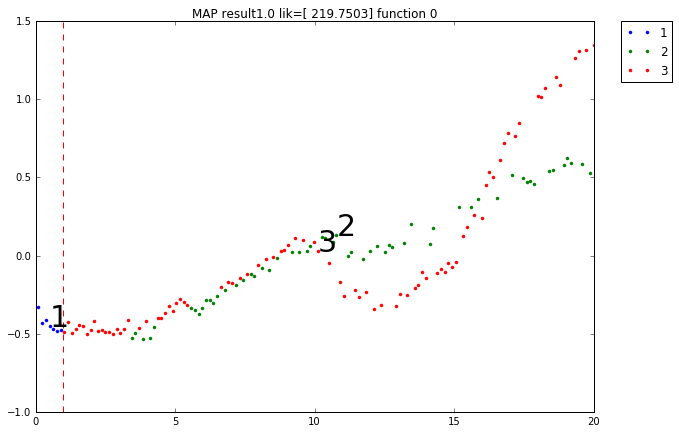

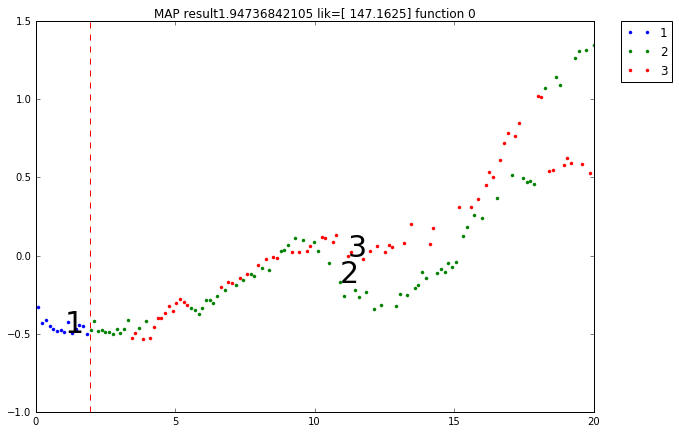

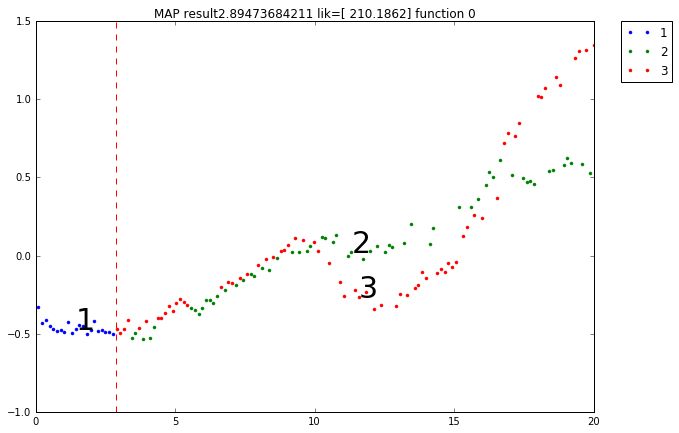

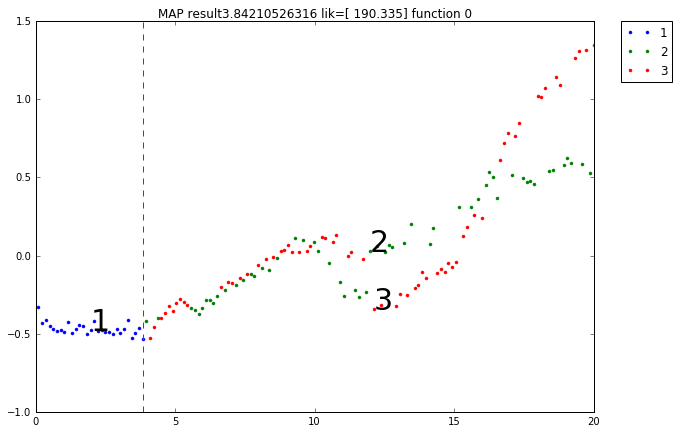

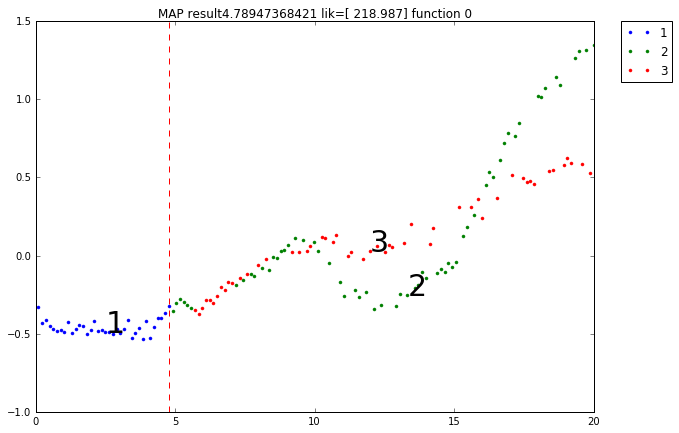

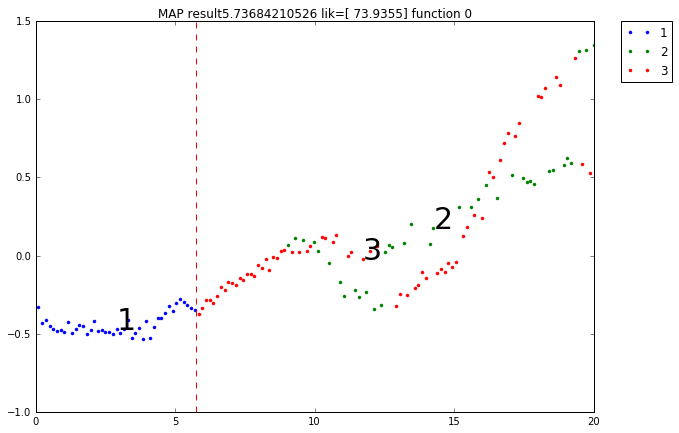

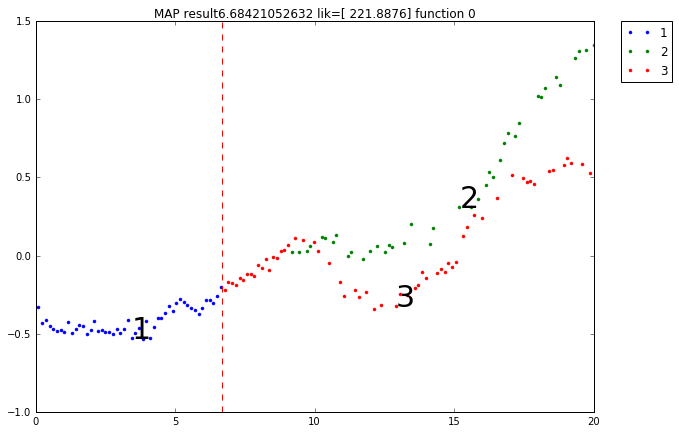

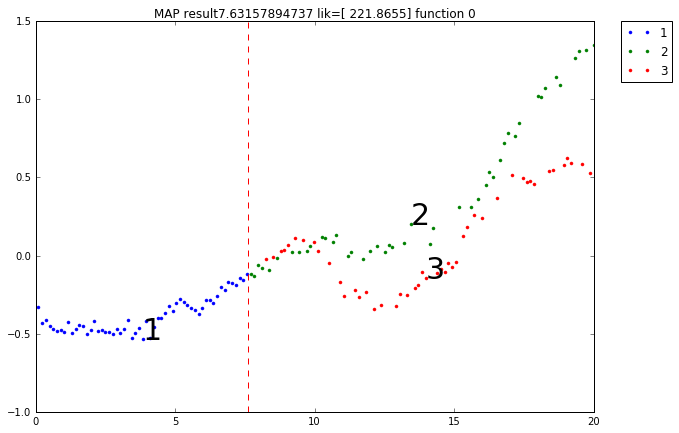

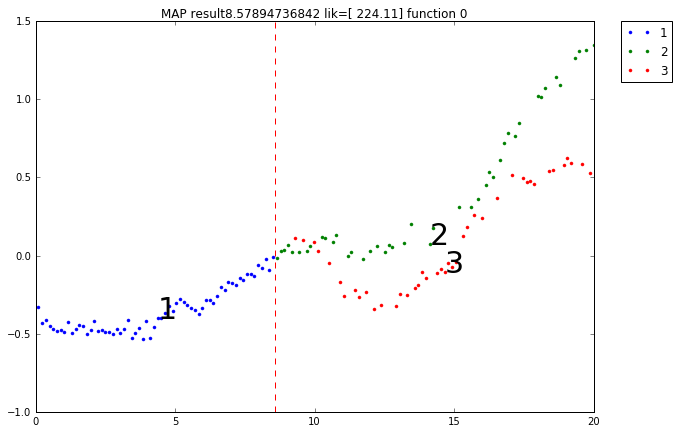

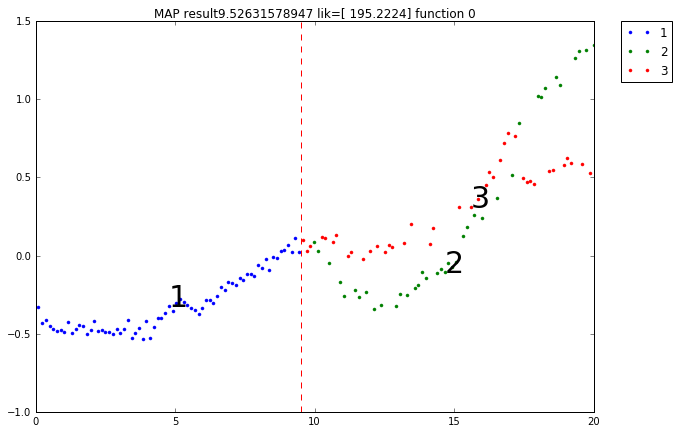

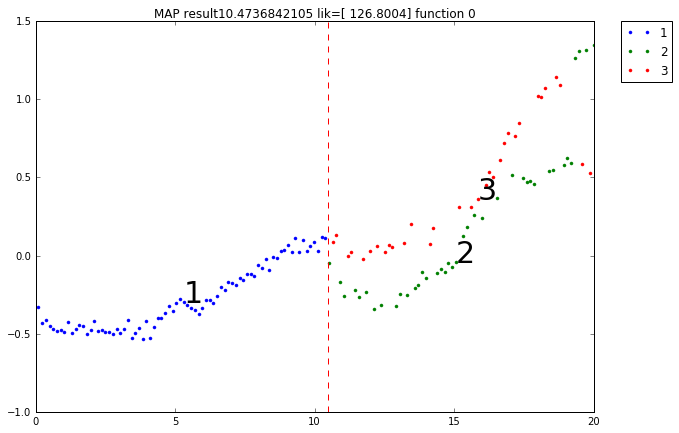

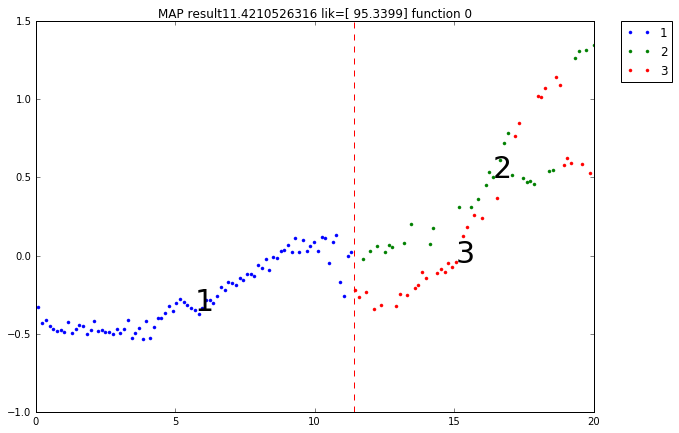

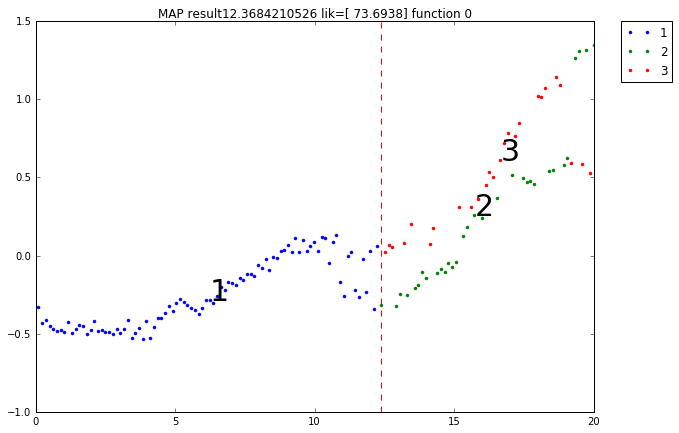

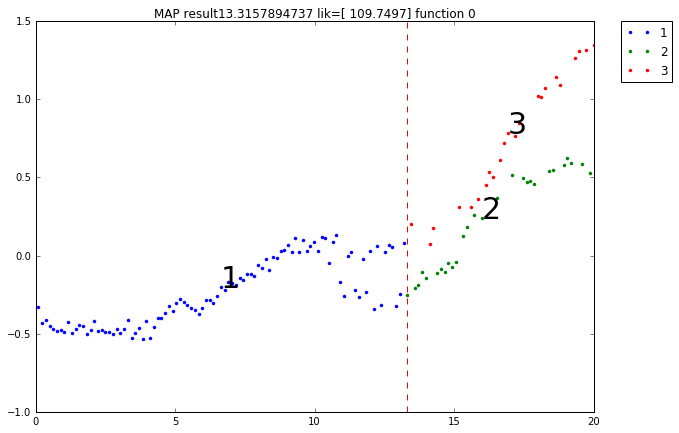

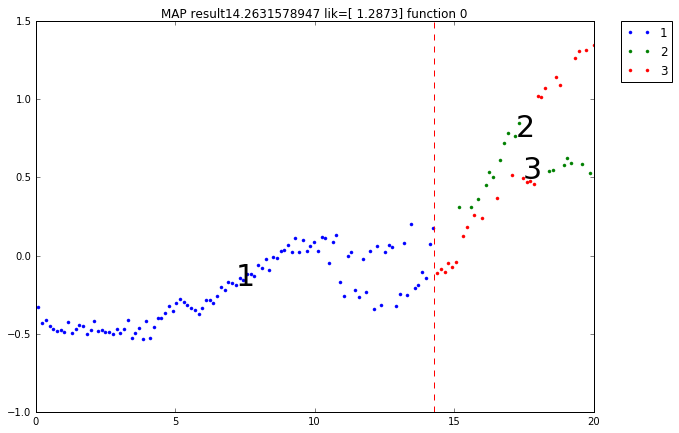

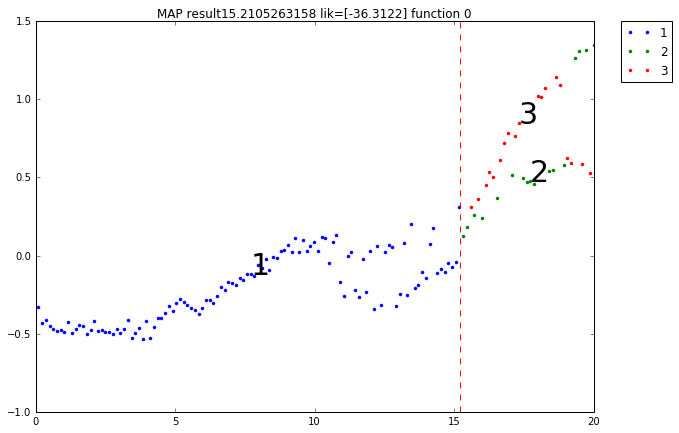

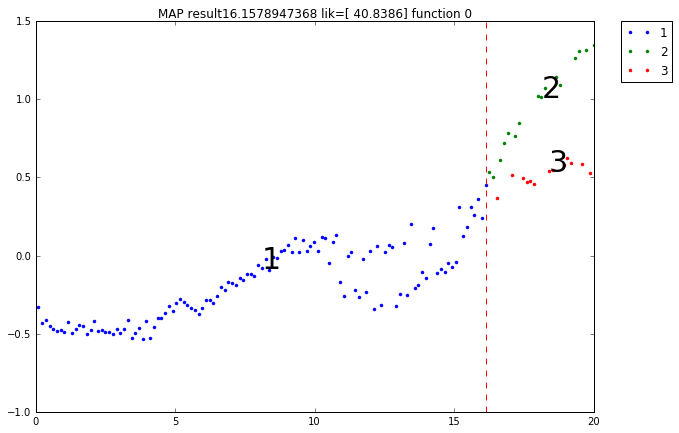

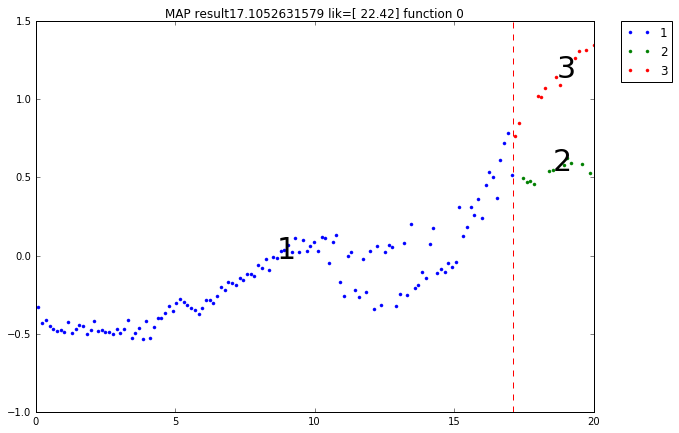

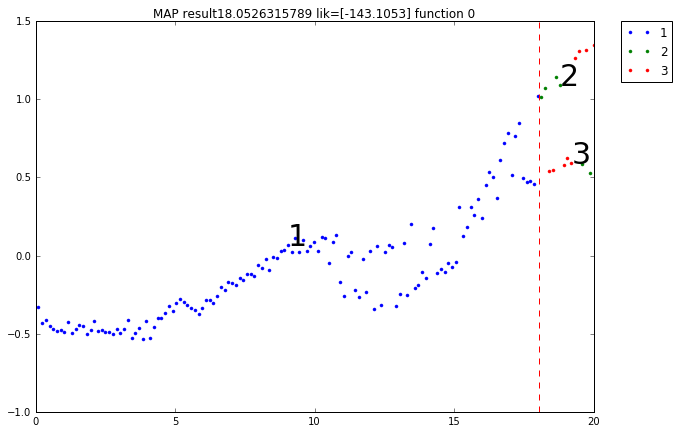

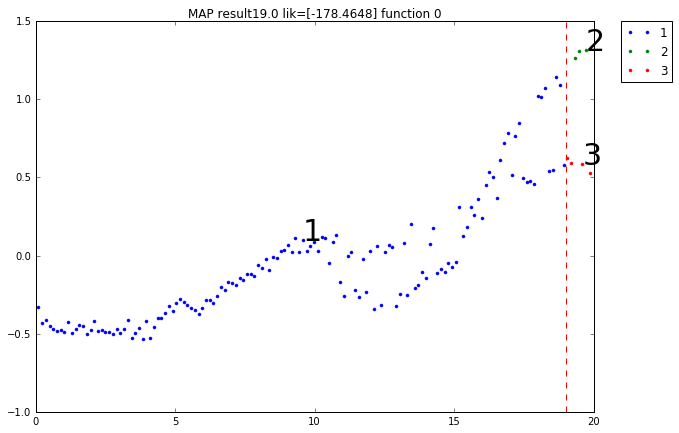

In [5]:
Bpossible = np.linspace(1,19,20)
logLike = []

logVBBound = []


start_time = time.time()

for b in Bpossible:
    Bcrap = np.atleast_2d(b) # crappy branch point

    # set branching point
    m.kern.branchkernelparam.Bv = Bcrap 

    print '============> B=' + str(m.kern.branchkernelparam.Bv.get_free_state())
    
    # Random assignment for given branch point
    randomAssignment = AssignGPGibbsSingleLoop.GetRandomInit(t,Bcrap,m.indices)
    #print m.XExpanded[randomAssignment,1]

    numMCMCsteps = 10
    #bestAssignment = list(randomAssignment)
    #chainState = np.ones(10)
    (chainState, bestAssignment) = m.InferenceGibbsMAP(fDebug=False,maximumNumberOfSteps=numMCMCsteps,\
                                                                 startingAssignment=randomAssignment)
        
    # TODO: extend to multiple branch points
    bk.PlotSample(D,m.XExpanded[bestAssignment, : ],3,Y,Bcrap,lw=3.,fs=30, figsizeIn=(10,7),title='MAP result'+str(b) + ' lik=' + str(chainState[-1]))
    logLike.append(chainState[-1])
    
    # Variational bound - no recomputing
    mV.kern.branchkernelparam.Bv = Bcrap
    print 'Variational kernel branch value ' + str(mV.kern.branchkernelparam.Bv.get_free_state())
    # Set state for assignments
    phiInitial =  np.zeros((N,3*N))
    for i,n in enumerate(bestAssignment):
        phiInitial[i,n] = 10
    mV.logPhi= phiInitial
    # Could also optimize!
    VBbound = mV._objective(mV.get_free_state())[0] # this is -log of bound
    
    logVBBound.append(VBbound)
    
    print 'B=' + str(b) + '. MAP lik=%.2f, VB bound=%.2f'%(chainState[-1],VBbound)    

elapsed_time = time.time() - start_time
print 'B=' + str(b) + ' elapsed times %.1f minutes.'%(elapsed_time/60.)

BestB = [10] estimated B 8.57894736842 with likelihood [ 224.11]


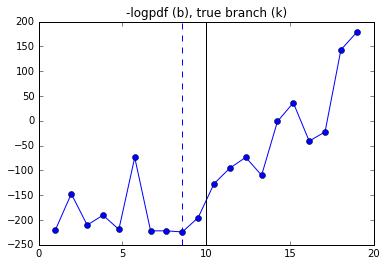

In [6]:
nlogL = -np.array(logLike)
iMin = np.argmin(nlogL)
plt.plot(Bpossible,nlogL, '-ob')
plt.title('-logpdf (b), true branch (k)')

v=plt.axis()
minB = Bpossible[iMin]
trueB = tree.GetBranchValues()

plt.plot([minB,minB],v[-2:],'--b')
plt.plot([trueB,trueB],v[-2:],'-k')

print 'BestB = ' +str(trueB) + ' estimated B ' + str(minB) + ' with likelihood ' + str(logLike[iMin])

BestB = [10] estimated B 8.57894736842 with marginal likelihood [ 125.6008]


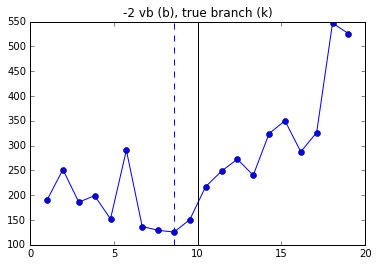

In [7]:
nlogL = np.array(logVBBound)
iMin = np.argmin(nlogL)
plt.plot(Bpossible,nlogL, '-ob')
plt.title('-2 vb (b), true branch (k)')

v=plt.axis()
minB = Bpossible[iMin]
trueB = tree.GetBranchValues()

plt.plot([minB,minB],v[-2:],'--b')
plt.plot([trueB,trueB],v[-2:],'-k')

print 'BestB = ' +str(trueB) + ' estimated B ' + str(minB) + ' with marginal likelihood ' + str(logVBBound[iMin])

mV = assigngp_dense.AssignGP(t, m.XExpanded, Y, Kbranch)
mV.kern.branchkernelparam.Bv.get_free_state()
mV.logPhi.get_free_state()

print mV.logPhi
print len(bestAssignment)
phiInitial =  np.zeros((N,3*N))

for i,n in enumerate(bestAssignment):
    phiInitial[i,n] = 10
    
mV.logPhi= phiInitial

mV._compile()
mV._objective(mV.get_free_state())[0]